# Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn.preprocessing as preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import time
import datetime
import sys
import os

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score

# Data loading

In [2]:
# Load preprocessed data
train_preprocess = pd.read_csv("../data/processed/train_preprocess.csv")
test_preprocess = pd.read_csv("../data/processed/test_preprocess.csv")

# Separate features and labels
y_train = train_preprocess["Label"]
y_test = test_preprocess["Label"]

# Extract weights
weights_train = train_preprocess["Weight"]
weights_test = test_preprocess["Weight"]

X_train = train_preprocess.drop(["Weight", "Label"], axis=1)
X_test = test_preprocess.drop(["Weight", "Label"], axis=1)


print("Data loaded successfully:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Data loaded successfully:
X_train shape: (589448, 17)
X_test shape: (104188, 17)


# Basic Logistic regression model

In [3]:
# Train a logistic regression model using L2 regularization and GridSearchCV

# Define a grid of lambda values (regularization strength)
lambda_grid = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Map to scikit-learn's C parameter (inverse of regularization strength)
C_grid = [1.0 / l for l in lambda_grid]

base_clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': C_grid}

grid = GridSearchCV(base_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
time_start = time.monotonic()
grid.fit(X_train, y_train)
train_end = time.monotonic()

best_clf = grid.best_estimator_
best_C = grid.best_params_['C']
best_lambda = 1.0 / best_C
print(f"GridSearchCV done. Best C={best_C} (lambda={best_lambda})")
print(f"Training time (including CV): {str(datetime.timedelta(seconds=train_end - time_start))}")

# Evaluate on test set using the best estimator
y_pred = best_clf.predict(X_test)
y_probs = best_clf.predict_proba(X_test)[:, 1]
test_end = time.monotonic()
print(f"Inference time: {str(datetime.timedelta(seconds=test_end - train_end))}")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV done. Best C=1000000.0 (lambda=1e-06)
Training time (including CV): 0:00:24.109829
Inference time: 0:00:00.019413
Accuracy: 0.7056090912581103
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     63612
           1       0.64      0.55      0.59     40576

    accuracy                           0.71    104188
   macro avg       0.69      0.68      0.68    104188
weighted avg       0.70      0.71      0.70    104188



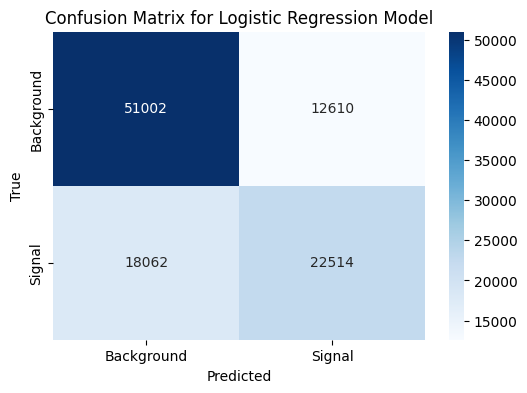

In [4]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
true_positives = cm[1, 1]
false_positives = cm[0, 1]
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

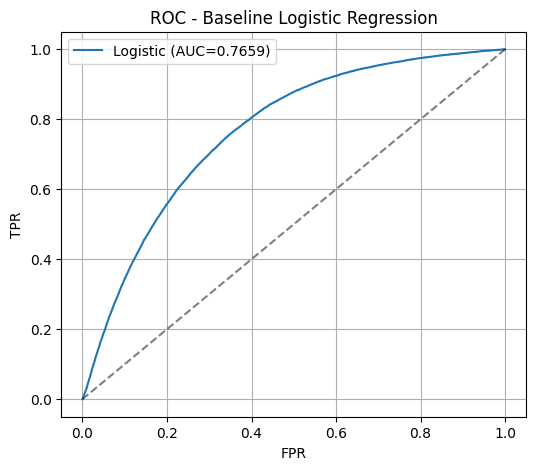

In [5]:
# ROC curve plot for baseline
fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label=1)
auc = roc_auc_score(y_test, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Baseline Logistic Regression")
plt.legend()
plt.grid(True)

In [6]:
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

ROC AUC Score: 0.7658549245607638


In [7]:
ams = ams_score(y_test, y_pred, weights_test)
print("AMS Score:", ams)

AMS Score: 0.743582495752626
